# Projet IA -- clustering

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pds
import seaborn as sns
import numpy as np
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from IPython.core.display import Image, display
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from plot_sklearn_dendrogram import plot_sklearn_dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
import graphviz 
from sklearn import tree
%matplotlib inline
np.random.seed(10)
random.seed(10)
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing # to scale data

## Définition des fonctions

In [107]:
# 3D plot using pyplot
def plot_km3d(km,df):
    """km est un objet de Kmeans. df est le dataframe correspondant sur lequel on a fait l'analyse."""
    fig = plt.figure() #opens a figure environment
    ax = Axes3D(fig) #to perform a 3D plot
    x=df.loc[:,'CO2']
    y=df.loc[:,'Population']
    z=df.loc[:,'Life_expectancy']
    ax.scatter(x, y, z,c=km.labels_.astype(np.float)) #plot definition and options 
    ax.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],km.cluster_centers_[:,2],c='r',s=100)
    # We set the colors to be in function of the labels of each cluster, ie each category
    # Cluster centers are in red
    ax.set_xlabel('CO2')
    ax.set_ylabel('Population')
    ax.set_zlabel('Life_expectancy')

In [94]:
def plot_dendro(df,km):
    """Plots the dendrogram for a specified clustering km and a table df.
    Returns the Agglomerative clustering object."""
    DF_Dendro1 = df.copy(deep=True)
    agc = AgglomerativeClustering(n_clusters=len(km.cluster_centers_), affinity="euclidean", linkage="complete")
    agc.fit(DF_Dendro1)
    plt.title('Hierarchical Clustering Dendrogram')
    plot_sklearn_dendrogram(agc, labels=agc.labels_)
    plt.show()
    return agc

## Data import

In [3]:
df = pds.read_csv('./Data2/Data2.txt', sep="\t") # load a pandas dataframe from csv

df.head()
#df.tail()

,Time,Time Code,Country Name,Country Code,Children out of school,CO2 emissions (kt),Non-renewable lectricity production (% of total),Renewable electricity production excluding hydroelectric (% of total),Life expectancy (years),Population,Rural population,Urban population,Surface area (sq. km)
0,2013,YR2013,Afghanistan,AFG,NaN,10014.577,NaN,NaN,62.494,31731688.0,23997724.0,7733964.0,652860.0
1,2013,YR2013,Albania,ALB,10957.0,5064.127,0.00000,0.0,77.702,2895092.0,1291587.0,1603505.0,28750.0
2,2013,YR2013,Algeria,DZA,NaN,134465.223,99.44899,0.0,75.418,38338562.0,11664124.0,26674438.0,2381740.0
3,2013,YR2013,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,55307.0,6997.0,48310.0,200.0
4,2013,YR2013,Andorra,AND,NaN,476.710,NaN,NaN,NaN,80788.0,9261.0,71527.0,470.0


# Data description

Les données rassemblent trois grands types de variables : <br>
- Des données environnementales (Ex  : production de polluants, production d'énergies verte ...)
- Des données sociologiques (Ex : Accès à l'éducation , Violoences faites aux femmes ...)
- Des données démographiques fondamentales (Ex : Espérance de vie , Population totale ...)

## Description des variables

* Colonne n°1 : Time => Année de l'étude
* Colonne n°2 : Time code
* Colonne n°3 : Contry name => pays étudiés
* Colonne n°4 : Country code


* Colonne n°5 : Annual freshwater withdrawals, total (billion cubic meters) <br>
    Quantité total d'eau douce consonmmée en millions de mètre cube. Cette métrique comprend l'ensemble des utilisations dues à des activités domestiques, industrielles où agricole. Elle soustrait les perte dues à l'évaporation. Enfin elle comprend l'eau produite par désalinisation. 

* Colonne n°6 : Children out of school, primary <br>
Nombre d'enfants de l'âge de l'école du primaire non scolarisés

<!-- ![Title](Children_Out_of_primary_school.png "Nombre d'enfants  (en million )d'âge du primaire non scolarisés entre 1970 et 2017") -->

* Colonne n°7 : CO2 emissions (kt) <br>
Emissin en CO2 en kilotonnes

![Title](EmissionCO22013.png)
*Rmq : On pourrait considérer cette variable en fonction du nombre total d'habitant par pays?*

* Colonne n°8 : Electricity production from oil, gas and coal sources (% of total) <br>
Pourcentage d'électricité produite via des ressources fossiles par rapport à la production totale d'électricité (données mondiales 2015)

![Title](Electricite_fossile2013.png)


* Colonne n°9 : Electricity production from renewable sources, excluding hydroelectric (% of total)
![Title](Electricite_verte_sauf_hydro_2013.png)

*Rmq : étonnante répartion, la production d'électricité verte ne semble pas liée au PIB (à démontrer)?*

* Colonne n°9 : Life expectancy at birth, total (years) 

* Colonne n°10 : PM2.5 air pollution, mean annual exposure (micrograms per cubic meter) <br>
**Definition**: Population-weighted exposure to ambient PM2.5 pollution is defined as the average level of exposure of a nation's population to concentrations of suspended particles measuring less than 2.5 microns in aerodynamic diameter, which are capable of penetrating deep into the respiratory tract and causing severe health damage. Exposure is calculated by weighting mean annual concentrations of PM2.5 by population in both urban and rural areas.
https://www.indexmundi.com/facts/indicators/EN.ATM.PM25.MC.M3
![Title](P.M.252016png.png)

*Rmq :Comment démontrer que la vie est injuste Rapport entre taux d'émisson et les Pm2.5 par pays *

* Colonne n°10 : Population, total 
* Colonne n°11 : Surface area (sq. km) 
* Colonne n°12 : Total greenhouse gas emissions (kt of CO2 equivalent) 
*Rmq : Cette dernière variable est peut etre redondante avec le taux d'émission de CO2*
* Colonne n°13 : Urban population 
<!--![Title](Poppulation_Urbaine_1960_2017.png)-->

*Rmq : quelle horrible exponentielle !*

* Colonne n°14 : Women who believe a husband is justified in beating his wife when she refuses sex with him (%) 

*rmq : Je pense qu il faudrait inclure le PIB meme si ce nest pas un indice par excellence. Ceci permettrait
    de creer des variables derivees comme le taux demisssion de poluants en fct de la ichesse produite, ou encore
    la production denergie verte par rapport au PiB (sur ceci on pourrait avoir des resultats surprenants).*

## Data cleaning

## Rename columns

In [4]:
df  = df.rename(index=str, columns={"Children out of school":"School", "CO2 emissions (kt)": "CO2" , "Non-renewable lectricity production (% of total)":"Fossile_electricity", "Renewable electricity production excluding hydroelectric (% of total)" : "Renewable_electricity", "Life expectancy (years)":"Life_expectancy" , "Rural population":"Rural" , "Urban population" : "Urban" ,"Surface area (sq. km)" : "Surface" } )

In [5]:
df.head()

,Time,Time Code,Country Name,Country Code,School,CO2,Fossile_electricity,Renewable_electricity,Life_expectancy,Population,Rural,Urban,Surface
0,2013,YR2013,Afghanistan,AFG,NaN,10014.577,NaN,NaN,62.494,31731688.0,23997724.0,7733964.0,652860.0
1,2013,YR2013,Albania,ALB,10957.0,5064.127,0.00000,0.0,77.702,2895092.0,1291587.0,1603505.0,28750.0
2,2013,YR2013,Algeria,DZA,NaN,134465.223,99.44899,0.0,75.418,38338562.0,11664124.0,26674438.0,2381740.0
3,2013,YR2013,American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,55307.0,6997.0,48310.0,200.0
4,2013,YR2013,Andorra,AND,NaN,476.710,NaN,NaN,NaN,80788.0,9261.0,71527.0,470.0


### Column cleaning

In [6]:
df.count() # Compte les non NaN par colonne

Time                     217
Time Code                217
Country Name             217
Country Code             217
School                   125
CO2                      206
Fossile_electricity      142
Renewable_electricity    141
Life_expectancy          199
Population               216
Rural                    214
Urban                    214
Surface                  217
dtype: int64

Les colonnes suivantes sont à supprimer (trop de NaN) : Annual freshwater, Total greenhouse gas emission, Women who believe...

# Row cleaning 

In [7]:
filtered_df = df.dropna(subset=['CO2', 'Population','Life_expectancy']) # On enlève toutes les lignes qui contiennent des NA

filtered_df.count()
# Les colonnes CO2, pop et life expectancy ont bien la même taille

Time                     192
Time Code                192
Country Name             192
Country Code             192
School                   122
CO2                      192
Fossile_electricity      138
Renewable_electricity    138
Life_expectancy          192
Population               192
Rural                    192
Urban                    192
Surface                  192
dtype: int64

## K-means

In [8]:
DF_kmeans1=filtered_df[['CO2','Population','Life_expectancy']]

## Normalisation des données

On analyse les données (pour savoir si on centre-réduit).
Ici, on va forcément centrer les données car les unités sont différentes.

1 - Centrage

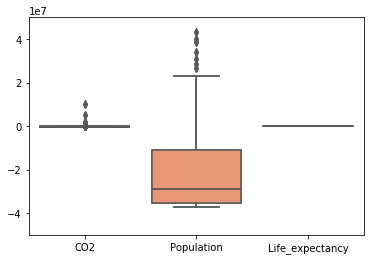

In [9]:
DF_kmeans1_centre =  DF_kmeans1 - DF_kmeans1.mean()
ax=sns.boxplot(data=DF_kmeans1_centre, orient="v", palette="Set2")
ax.set_ylim(-0.5e8,0.5e8)
sns.boxplot(data=DF_kmeans1_centre, orient="v", palette="Set2")

2- Réduction

(-2, 2)

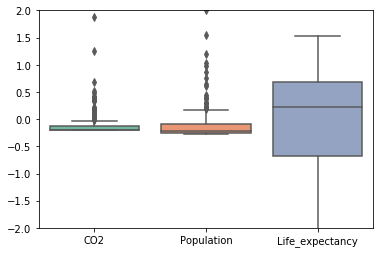

In [10]:
DF_kmeans1 =  ( DF_kmeans1 - DF_kmeans1.mean() )/ DF_kmeans1.std()
ax=sns.boxplot(data=DF_kmeans1, orient="v", palette="Set2")
ax.set_ylim(-2,2)
# C'est mieux. On a gardé trop d'outliers ?

### Premier cas simple pour bien comprendre

On étudie déjà les outliers, avant d'exécuter l'algorithme des Kmeans. Pour cela nous allons utiliser DBSCAN, on considerera que les 'noise points' sont les outliers. Le problème est alors d'estimer les paramètres en entrée de DBSCAN : soit le nombre de points minimum devant se trouver dans un rayon donné, pour considérer un cluster. Pour ce faire nous allons tracer le graphique de la distance au quatrième voisin le plus proche en utilisant les données de KNN.

In [13]:
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(DF_kmeans1)
distances, indices = nbrs.kneighbors(DF_kmeans1)
distances_to_4 = distances[:,3]
distances_to_4 = sorted(distances_to_4 , reverse = False)
#distances_to_4

[0.012577910067195318,
 0.01787286225317983,
 0.020170403570467288,
 0.020170403570467288,
 0.020372525478465214,
 0.02424444568674503,
 0.025802562578502608,
 0.026575435134236238,
 0.026658536353324564,
 0.026658536353324564,
 0.028368087322236373,
 0.029088840786745757,
 0.029088840786745757,
 0.03127756189763869,
 0.0318890070834813,
 0.0318890070834813,
 0.032984467649504974,
 0.03326191691933882,
 0.03326191691933882,
 0.03388425245756932,
 0.03473356416310423,
 0.03498987492217623,
 0.03594305891469891,
 0.037611986320831306,
 0.03832925225290059,
 0.03840544783193401,
 0.03840544783193401,
 0.03874705952052905,
 0.0389658521908348,
 0.03928314173392803,
 0.040842850717765104,
 0.041565898975814294,
 0.04188093479221732,
 0.044202465705265474,
 0.045537135888682086,
 0.04579253153861278,
 0.04638810682994674,
 0.04763978447839442,
 0.04828430672805711,
 0.04974922384868309,
 0.04990887440588948,
 0.05052388360443308,
 0.051182493388716235,
 0.051182493388716235,
 0.0518267767807

1.3527450344278238

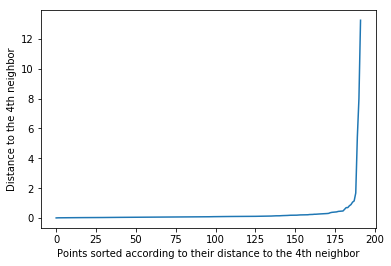

In [14]:
Index = range(0,len(distances_to_4))
plt.plot(Index , distances_to_4)
plt.xlabel('Points sorted according to their distance to the 4th neighbor')
plt.ylabel('Distance to the 4th neighbor')
mean_dist_knee = sum(distances_to_4[180:190])/10
mean_dist_knee

Le graphique ci-desssus nous permet d'observer 'un coude'. Autrement dit la distance au quatrième voisin est relativement stable pour les 175 première valeur, puis augmente brusquement. Nous utliserons la distance moyenne calculée au niveau du coude (mean_dist_knee ) comme paramètre de DBSCAN.

In [17]:
outliers_det = DBSCAN(min_samples=2,eps=mean_dist_knee).fit(DF_kmeans1)
# Number of outliers
sum(outliers_det.labels_ == -1) 

4

D'après nos paramètres, nous repérons 4 outliers, ce qui peut largement être discuté ! 

## Analyse des résultats de DBSCAN

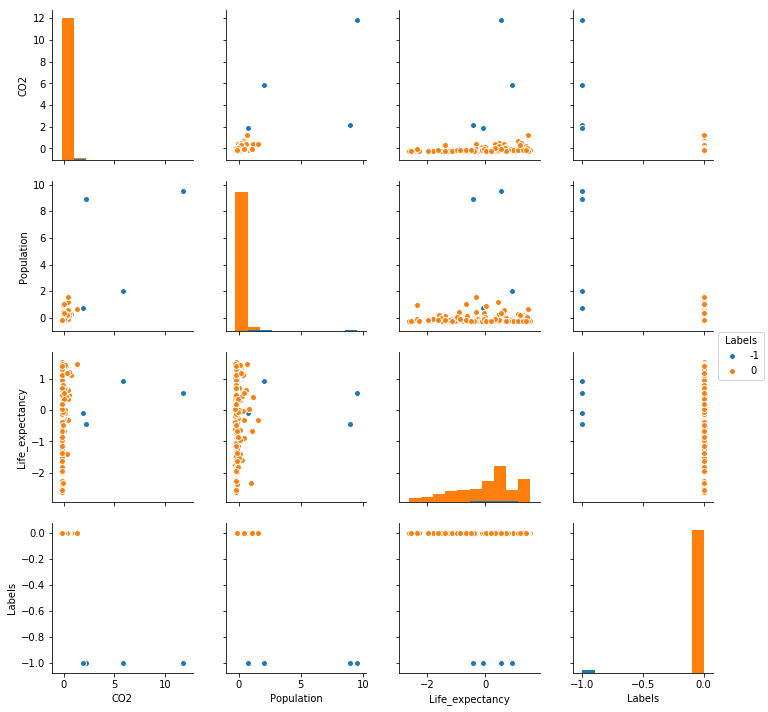

In [26]:
DF_kmeans1['Labels']=outliers_det.labels_
sns.pairplot(data=DF_kmeans1,hue='Labels') # les labels ne nous servent pas
plt.show()
# Les -1 permettent de repérer les outliers

D'après nos paramètres DBSCAN crée 2 groupes, et un cluster d'outliers constitué de 4 pays. Dans les pays exclus on retrouve la Chine et l'Inde à cause de leur grande population, mais aussi les Etats-Unis (gros taux de CO2) et la Russie (à cause du CO2 ?)

In [34]:
DF_kmeans1_C= DF_kmeans1.copy(deep=True) # Copy of DF_kmeans1
DF_kmeans1_C['Country'] = df['Country Name']
DF_kmeans1_C.head()

print(DF_kmeans1_C[DF_kmeans1_C['Labels'] == -1])

           CO2  Population  Life_expectancy  Labels             Country
41   11.810629    9.510340         0.549868      -1               China
89    2.178481    8.942533        -0.433087      -1               India
161   1.878397    0.765541        -0.083496      -1  Russian Federation
206   5.838196    2.009879         0.912599      -1       United States


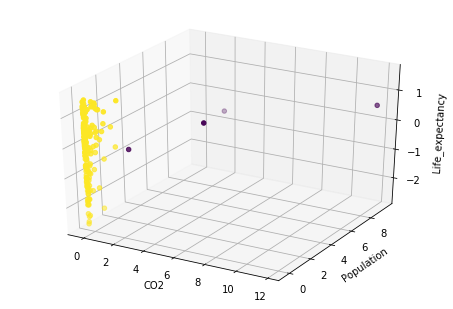

In [54]:
# 3D plot using pyplot
fig = plt.figure() #opens a figure environment
ax = Axes3D(fig) #to perform a 3D plot
x=DF_kmeans1_C.loc[:,'CO2']
y=DF_kmeans1_C.loc[:,'Population']
z=DF_kmeans1_C.loc[:,'Life_expectancy']
ax.scatter(x, y, z,c=outliers_det.labels_.astype(np.float)) #plot definition and options 
ax.set_xlabel('CO2')
ax.set_ylabel('Population')
ax.set_zlabel('Life_expectancy')

## Implémentation de Kmeans

On enlève les outliers trouvés avec DBscan.

In [42]:
DF_kmeans1_C2=DF_kmeans1_C[DF_kmeans1_C.Labels != -1]
len(DF_kmeans1_C2)
#len(DF_kmeans1_C)

188

In [47]:
DF_kmeans1_C2.drop('Labels',axis=1)

,CO2,Population,Life_expectancy,Country
0,-0.193155,-0.039692,-1.070085,Afghanistan
1,-0.198954,-0.247433,0.785753,Albania
2,-0.047383,0.007904,0.507036,Algeria
5,-0.166679,-0.080996,-1.328912,Angola
6,-0.204272,-0.267584,0.564878,Antigua and Barbuda
7,0.017493,0.038171,0.588918,Argentina
8,-0.198447,-0.247444,0.339366,Armenia
9,-0.203876,-0.267546,0.509720,Aruba
10,0.231161,-0.101545,1.328395,Australia
11,-0.131694,-0.207200,1.204877,Austria


In [52]:
DF_kmeans1_C3=DF_kmeans1_C2[['CO2','Population','Life_expectancy']]

In [55]:
kmdb = KMeans(n_clusters=3) # create a KMeans object
kmdb.fit(DF_kmeans1_C3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

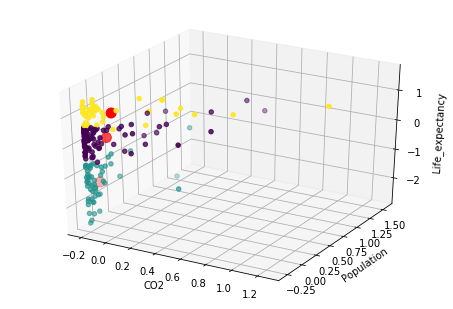

In [77]:
plot_km3d(kmdb,DF_kmeans1_C3)

# Dendrogramme estimation du nombre de clusters

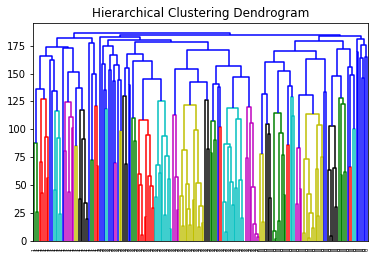

In [100]:
AGC=plot_dendro(DF_kmeans1_C3,kmdb)

## Troncature du dendrogramme

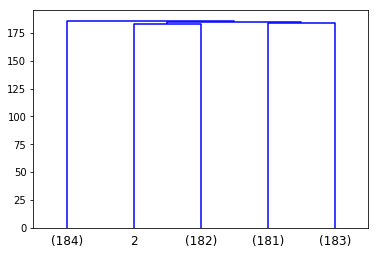

In [103]:
trunc=5
plot_sklearn_dendrogram(AGC, labels=AGC.labels_, truncate_mode='lastp', p=trunc)

### Relance de Kmeans avec un autre nb de clusters

In [104]:
kmdb4 = KMeans(n_clusters=4) # create a KMeans object
kmdb4.fit(DF_kmeans1_C3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

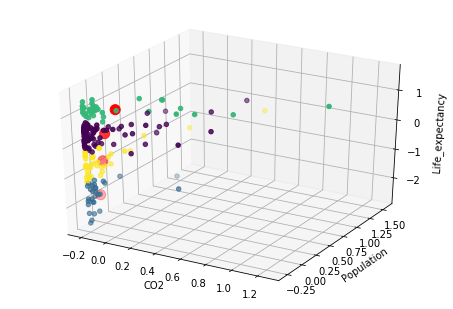

In [108]:
plot_km3d(kmdb4,DF_kmeans1_C3)

Qualitativement : pas de différence importante.

# Une autre façon de définir les outliers

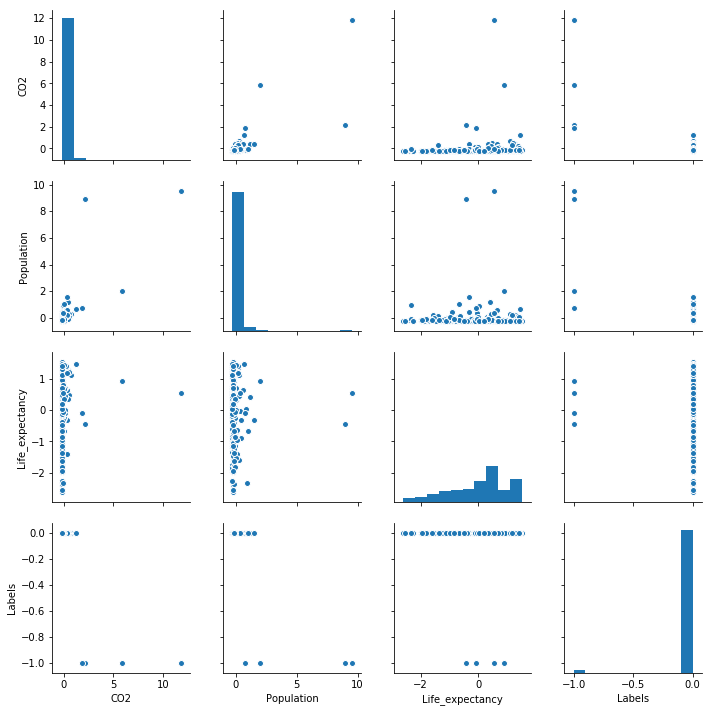

In [33]:
dfScatterPlot = sns.pairplot(data=DF_kmeans1)

On remarque 7 points extrêmes pour la population et 5 pour le CO2. Cependant, il est difficile de les identifier (on pourrait utiliser la distance de Cook ?)

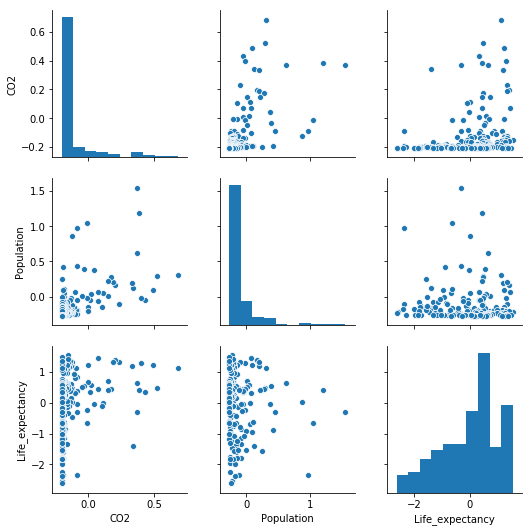

In [42]:
# Outliers du CO2
DF_kmeans_CO2 = DF_kmeans1.sort_values(by =['CO2'] , ascending = False)[5: ][ : ] # Remove Outliers
sns.pairplot(data=DF_kmeans_CO2)

Il reste 6 outliers de population.

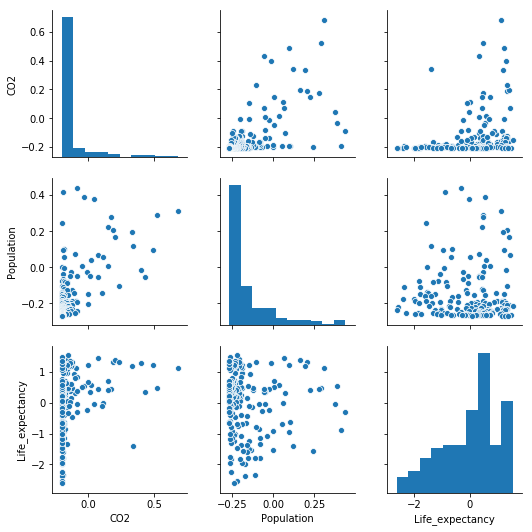

In [43]:
DF_kmeans_pop = DF_kmeans_CO2.sort_values(by =['Population'] , ascending = False)[6: ][ : ] # Remove Outliers
sns.pairplot(data=DF_kmeans_pop)

In [109]:
DF_kmeans1=DF_kmeans_pop # Pour garder les données sans outliers
DF_kmeans1.head()
#DF_kmeans1 = DF_kmeans1.drop(columns="Labels")


,CO2,Population,Life_expectancy
155,-0.089944,0.441173,-0.315205
64,-0.192430,0.415287,-0.892165
211,-0.032431,0.390865,0.536933
58,0.045090,0.378688,-0.040271
73,0.682177,0.312686,1.126004


In [70]:
km1 = KMeans(n_clusters=3) # create a KMeans object
km1.fit(DF_kmeans1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5,0,'Life_expectancy')

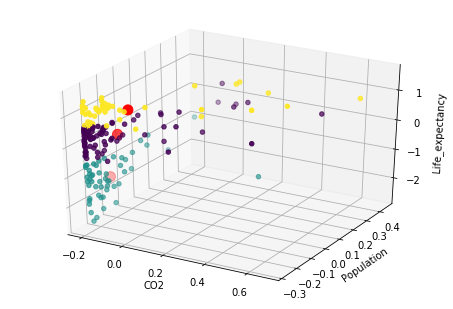

In [111]:
# 3D plot using pyplot
fig = plt.figure() #opens a figure environment
ax = Axes3D(fig) #to perform a 3D plot
x=DF_kmeans1.loc[:,'CO2']
y=DF_kmeans1.loc[:,'Population']
z=DF_kmeans1.loc[:,'Life_expectancy']
ax.scatter(x, y, z,c=km1.labels_.astype(np.float)) #plot definition and options 
ax.scatter(km1.cluster_centers_[:,0],km1.cluster_centers_[:,1],km1.cluster_centers_[:,2],c='r',s=100) #plot definition and options 
# We set the colors to be in function of the labels of each cluster, ie each category
# Cluster centers are in red
ax.set_xlabel('CO2')
ax.set_ylabel('Population')
ax.set_zlabel('Life_expectancy')

In [113]:
clusters = km1.labels_
#DF_kmeans1['Clusters_km1'] = clusters
DF_kmeans1.head()


,CO2,Population,Life_expectancy
155,-0.089944,0.441173,-0.315205
64,-0.192430,0.415287,-0.892165
211,-0.032431,0.390865,0.536933
58,0.045090,0.378688,-0.040271
73,0.682177,0.312686,1.126004


On remarque que l'espérance de vie n'est pas caractéristique d'un groupe. 
Ici, les clusters sont elliptiques et donc les groupes sont difficiles à trouver.
Cependant la population et le CO2 semble corrélés nous allons le vérifier dans Kmeans2.

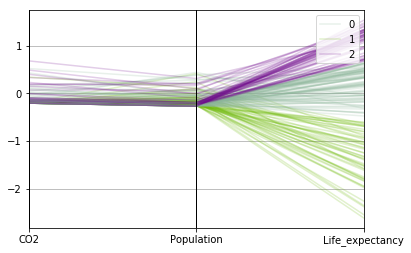

In [114]:
from pandas.plotting import parallel_coordinates
DF_kmeans1['Labels']=km1.labels_

parallel_coordinates(DF_kmeans1,'Labels', alpha=0.2)
plt.show()

## Analyse

In [115]:
# On enlève les labels rajoutés ci-dessus
DF_kmeans1=DF_kmeans1.drop('Labels',axis=1)

### Qualité du clustering

#### SSE

In [116]:
sse = []
Ks = range(1, 15)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
    km.fit(DF_kmeans1)
    #distance.append(np.sqrt(km.inertia_))
    sse.append(km.inertia_)

Text(0,0.5,'SSE')

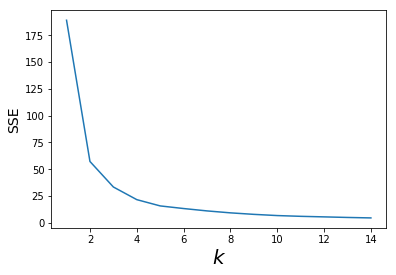

In [117]:
plt.plot(Ks,sse)
plt.xlabel("$k$",fontsize=20)
plt.ylabel("SSE",fontsize=14)

#### Silhouette

In [123]:
from sklearn.metrics import silhouette_score
silhouette_coef = []
Ks = range(2, 30)
for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=k) # create a KMeans object
    km.fit(DF_kmeans1)
    labels = km.predict(DF_kmeans1)
    silhouette_coef.append(silhouette_score(DF_kmeans1, labels, metric='euclidean', sample_size=None))

Text(0,0.5,'Silhouette Coef.')

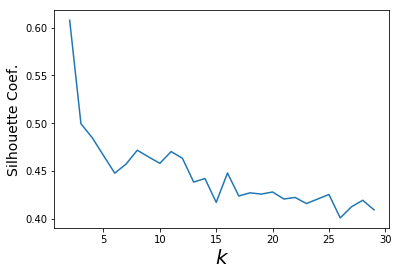

In [124]:
plt.plot(Ks,silhouette_coef)
plt.xlabel("$k$",fontsize=20)
plt.ylabel("Silhouette Coef.",fontsize=14)

Ici on ne voit pas de pics "clairs" du coefficient Silhouette. Le max local intéressant peut être celui à 5 clusters.

### Stabilité

In [125]:
silhouette_coef = []
sse = []
k = 3
n_init=1
for i in range(100):
    km = KMeans(n_clusters=k, n_init=n_init, random_state=i) # create a KMeans object
    km.fit(DF_kmeans1)
    labels = km.predict(DF_kmeans1)
    sse.append(km.inertia_)
    silhouette_coef.append(silhouette_score(DF_kmeans1, labels, metric='euclidean', sample_size=None))

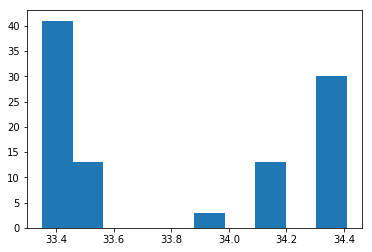

In [126]:
_ = plt.hist(sse)

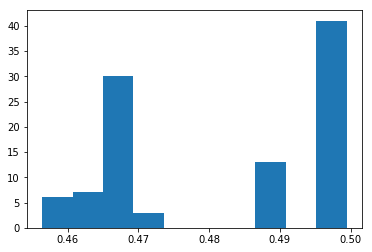

In [127]:
_ = plt.hist(silhouette_coef)

#### With different cluster numbers

In [128]:
def compute_stability(k,df,iterations=100):
    silhouette_coef = []
    for i in range(iterations):
        km = KMeans(n_clusters=k, n_init=1, random_state=i) # create a KMeans object
        km.fit(DF_kmeans1)
        labels = km.predict(DF_kmeans1)
        silhouette_coef.append(silhouette_score(DF_kmeans1, labels, metric='euclidean', sample_size=None))
    silhouette_coef = np.asarray(silhouette_coef)
    return(silhouette_coef.std())

In [129]:
stability = []
Ks = range(2,30)
for k in Ks:
    stability.append(compute_stability(k,DF_kmeans1))

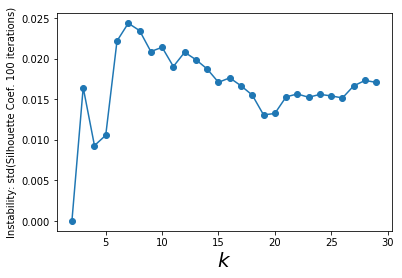

In [130]:
plt.plot(Ks,stability,"o-")
plt.xlabel("$k$",fontsize=20)
plt.ylabel("Instability: std(Silhouette Coef. 100 iterations)")
plt.show()

On voit que ce clustering est très instable autour des 5 clusters choisis... 

# Kmeans 2


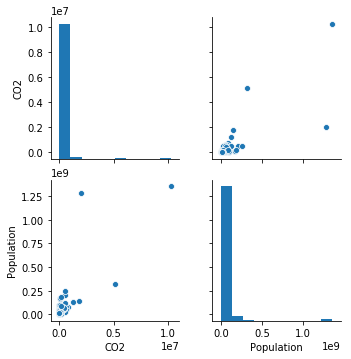

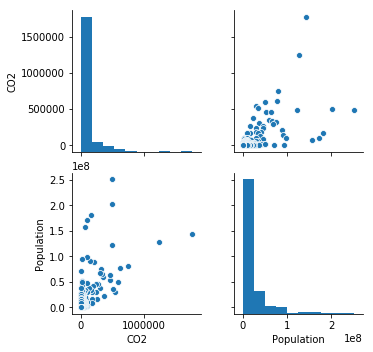

In [131]:
DF_kmeans2 = filtered_df[['CO2'  , 'Population' ]] 
dfScatterPlot = sns.pairplot(data=DF_kmeans2)

DF_kmeans2 = DF_kmeans2.sort_values(by =['CO2'] , ascending = False)[3: ][ : ] # Remove Outliers
dfScatterPlot = sns.pairplot(data=DF_kmeans2)

In [132]:
km2 = KMeans(n_clusters=3) # create a KMeans object
km2.fit(DF_kmeans2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

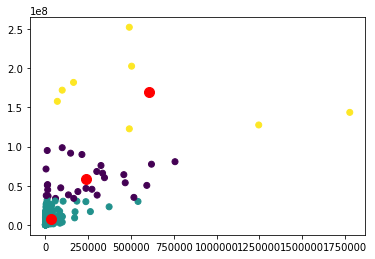

In [133]:
plt.scatter(data=DF_kmeans2, x="CO2", y="Population" , c=km2.labels_.astype(np.float))
plt.scatter(km2.cluster_centers_[:,0],km2.cluster_centers_[:,1],c='red',s=100)


On observe d'après ce graphique les limites du Kmeans 

### Vision d'ensemble des données

## Contingence DBSCAN et KMEAN

In [154]:
df_GDP = pds.read_csv('./Data_GDP/Data_GDP.txt', sep="\t") # load a pandas dataframe from csv

DF_kmeans1.index

Index([u'155', u'64', u'211', u'58', u'73', u'91', u'198', u'44', u'192',
       u'68',
       ...
       u'78', u'195', u'129', u'9', u'6', u'169', u'21', u'77', u'65', u'114'],
      dtype='object', length=181)

Nous utiserons la GDP comme classe étiquette

# Arbre de décision -> enveloppe des cluster

In [170]:
Tree_enveloppe = DF_kmeans1.copy(deep=True)
Tree_enveloppe['Labels']=km1.labels_
classes=Tree_enveloppe['Labels']
features=Tree_enveloppe.drop('Labels',axis=1)

In [182]:
model  = DecisionTreeClassifier(criterion = 'entropy') # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
model.fit(features , classes)
sortedLabelList = ['0', '1', '2']

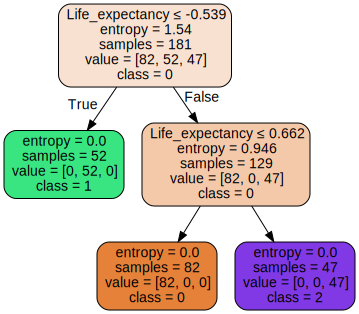

In [183]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=features.columns,  
                         class_names=(sortedLabelList),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#  Arbre de décision sur CO2

In [222]:
def kmeans_1D(attribute,n):
    """Prend en entrée un nparray et n clusters"""
    km1 = KMeans(n_clusters=n) # create a KMeans object
    km1.fit(V_Life_expectancy.reshape(-1,1))
    return km1

In [223]:
def plot_pred_nbclusters(attr):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at =attr
    x_ind = range(0, len(at))
    plt.hist(at )
    plt.show()

In [224]:
def plot_kmeans1D(attr,labels):
    """Entree : liste ou nparray"""
   # at  = sorted(attr )
    at = attr
    x_ind = range(0, len(at))
    plt.hist(at);

    plt.show()

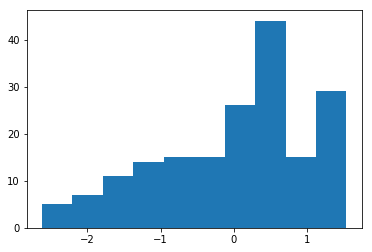

In [227]:
V_Life_expectancy  = np.array(DF_kmeans1['Life_expectancy'])
plot_pred_nbclusters(V_Life_expectancy)
KM_LE = kmeans_1D(V_Life_expectancy , 3)

#plot_kmeans1D(V_Life_expectancy,KM.labels_)

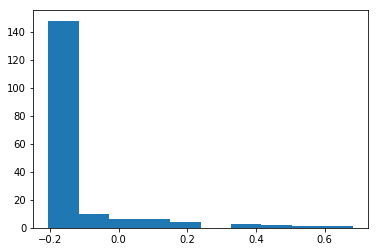

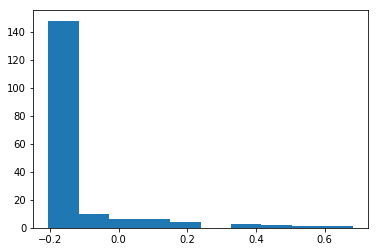

In [228]:
V_CO2  = np.array(DF_kmeans1['CO2'])
plot_pred_nbclusters(V_CO2)
KM_CO2 = kmeans_1D(V_CO2 , 2)

plot_kmeans1D(V_CO2,KM.labels_)

# Arbre de décision sur avec classe en fonction des sorties de Kmeans LE

In [234]:
Tree_LE = DF_kmeans1.copy(deep=True)
Tree_LE['Labels']=KM_LE.labels_
classes=Tree_LE['Labels']
features=Tree_LE.drop('Labels',axis=1)
Tree_LE =Tree_LE.drop('Life_expectancy',axis=1)

model  = DecisionTreeClassifier(criterion = 'entropy') # part aleatoire si deux split possibles 
                                                    # surtout si deux index sous equivalent gini entropy ...
clf = model.fit(features , classes)
sortedLabelList = ['0', '1', '2']

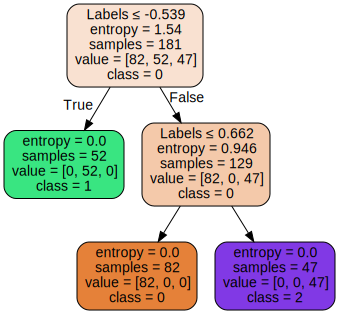

In [236]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=Tree_LE.columns,  
                         class_names=sortedLabelList,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 